# Deblending with *Scarlet*
<br>Owner(s): **Fred Moolekamp** ([@fred3m](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@fred3m))
<br>Level: **Intermediate**
<br>Last Verified to Run: **2021-03-26**
<br>Verified Stack Release: **v21.0.0**

The purpose of this tutorial is to familiarize you with the basics of using `scarlet` to model blended scenes, and how tweaking various objects and parameters affects the resulting model. This tutorial use `scarlet` as a stand-alone package, and does not depend on the LSST DM Science Pipelines. This notebook was developed from an early version of the [scarlet quickstart tutorial](https://pmelchior.github.io/scarlet/0-quickstart.html). A tutorial that is more focused on using `scarlet` in the context of the LSST DM Science Pipelines is available at [Deblending/LsstStackDeblender.ipynb](../Deblending/LsstStackDeblender.ipynb).

### Learning Objectives:

After working through this tutorial you should be able to: 
1. Configure and run `scarlet` on a test list of objects;
2. Understand its various model assumptions and applied constraints.

More documentation is available on in the `scarlet` [docs](https://pmelchior.github.io/scarlet/) and the core concepts of the code are discussed [here](https://pmelchior.github.io/scarlet/1-concepts.html).

### Logistics
This notebook is intended to be runnable on `lsst-lsp-stable.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.

## Setup

In [1]:
# What version of the Stack are we using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

nb-kadrlica-r21-0-0
lsst_distrib          21.0.0+973e4c9e85 	current v21_0_0 setup


In [2]:
# Import the necessary libraries
import os

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# don't interpolate the pixels
matplotlib.rc('image', interpolation='none')

import numpy as np
from astropy.visualization.lupton_rgb import AsinhMapping

import scarlet
import scarlet.display
from astropy.visualization.lupton_rgb import AsinhMapping, LinearMapping

In [3]:
print("scarlet: %s"%scarlet.__version__)

scarlet: 1.0.1+unknown


# Display functions

Below are several useful functions used throughout this tutorial to visualize the data and models.

In [4]:
def show_psfs(psfs, filters, norm=None):
    rows = int(np.ceil(len(psfs)/3))
    columns = min(len(psfs), 3)
    figsize = (45/columns, rows*5)
    fig = plt.figure(figsize=figsize)
    ax = [fig.add_subplot(rows, columns, n+1) for n in range(len(psfs))]
    for n, psf in enumerate(psfs):
        im = ax[n].imshow(psf, norm=norm)
        ax[n].set_title("{0}-band PSF".format(filters[n]))
        plt.colorbar(im, ax=ax[n])
    plt.show()

def display_diff_kernels(psf_blend, diff_kernels):
    model = psf_blend.get_model()
    for b, component in enumerate(psf_blend.components):
        fig = plt.figure(figsize=(15,2.5))
        ax = [fig.add_subplot(1,4,n+1) for n in range(4)]
        # Display the psf
        ax[0].set_title("psf")
        _img = ax[0].imshow(psfs[b])
        fig.colorbar(_img, ax=ax[0])
        # Display the model
        ax[1].set_title("modeled psf")
        _model = np.ma.array(model[b], mask=model[b]==0)
        _img = ax[1].imshow(_model)
        fig.colorbar(_img, ax=ax[1])
        # Display the difference kernel
        ax[2].set_title("difference kernel")
        _img = ax[2].imshow(np.ma.array(diff_kernels[b], mask=diff_kernels[b]==0))
        fig.colorbar(_img, ax=ax[2])
        # Display the residual
        ax[3].set_title("residual")
        residual = psfs[b]-model[b]
        vabs = np.max(np.abs(residual))
        _img = ax[3].imshow(residual, vmin=-vabs, vmax=vabs, cmap='seismic')
        fig.colorbar(_img, ax=ax[3])
        plt.show()

# Load and Display the data

The `file_path` points to a directory with 147 HSC blends from the COSMOS field detected by the LSST pipeline. Changing `idx` below will select a different blend.

--2021-04-23 20:41:34--  https://github.com/pmelchior/scarlet/raw/master/data/hsc_cosmos_35.npz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pmelchior/scarlet/master/data/hsc_cosmos_35.npz [following]
--2021-04-23 20:41:35--  https://raw.githubusercontent.com/pmelchior/scarlet/master/data/hsc_cosmos_35.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242498 (237K) [application/octet-stream]
Saving to: ‘hsc_cosmos_35.npz’

100%[======================================>] 242,498     --.-K/s   in 0.02s   

2021-04-23 20:41:35 (15.4 MB/s) - ‘hsc_cosmos_35.npz’ saved [242498/242498]

Background R

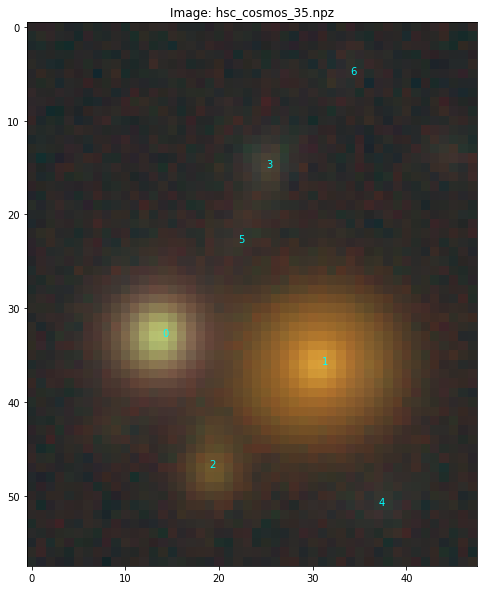

In [5]:
# Load the sample images
filename = 'hsc_cosmos_35.npz'
if not os.path.exists(filename): 
    github="https://github.com/pmelchior/scarlet/raw/master/data/"
    !wget {github}{filename}
data = np.load(filename)

images = data["images"]
weights = 1/data["variance"]
peaks = data["catalog"]
psfs = data["psfs"]
filters = ["G", "R", "I", "Z", "Y"]

# Only a rough estimate of the background is needed
# to initialize and resize the sources
bg_rms = np.std(images, axis=(1,2))
print("Background RMS: {0}".format(bg_rms))

# Use Asinh scaling for the images
norm = AsinhMapping(minimum=images.min(), stretch=images.max()/20, Q=10)

# Convert the image to an RGB image
plt.figure(figsize=(10,10))
img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
plt.imshow(img_rgb)
plt.title("Image: {}".format(filename))
for k, src in enumerate(peaks):
    plt.text(src[0], src[1], str(k), color="cyan")
plt.show()

## Display PSFs

We can also take a  look at the `psfs`

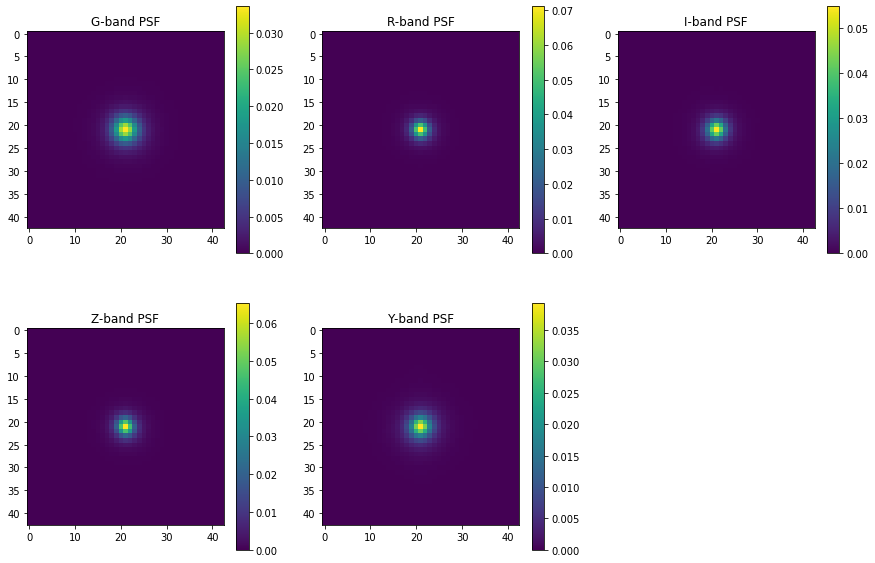

In [6]:
show_psfs(psfs, filters)

# Define the model and observation frames

A `Frame` in scarlet is the metadata that defines the hyperspectral data cube, including dimensions, WCS (optional), and the PSF (technically optional but recommended). So we need to define a frame for our model and for the `Observation`, which contains the image and variance data for the observations of the scene that we are deblending.  We will create an initial model `Frame` that uses a narrow Gaussian PSF and an `Observation` that consists of multiple bands of an HSC coadded image. See https://pmelchior.github.io/scarlet/1-concepts.html for more on `Frame`s and `Observation`s.

In scarlet it is possible to deblend scenes that have observations with different instruments that have different resolutions and/or observations that have not been coadded; however, that is outside the scope of this tutorial and the interested reader is referred to https://pmelchior.github.io/scarlet/tutorials/multiresolution.html.

In [7]:
# Image psfs
psf = scarlet.ImagePSF(psfs)
# We need to provide a reference PSF for the model. We choose a minimal Gaussian PSF as our reference kernel
model_psf = scarlet.GaussianPSF(sigma=(0.9,)*len(filters))

# Create the initial frame (metadata for the model).
frame = scarlet.Frame(images.shape, psfs=model_psf, channels=filters)

# Create our observation
observation = scarlet.Observation(images, psfs=psf, channels=filters, weights=weights).match(frame)

# Initializing Sources

Astrophysical objects are modeled in scarlet as a collection of components, where each component has a single SED that is constant over it's morphology (band independent intensity). So a single source might have multiple components, like a bulge and disk, or a single component.

The different classes that inherit from `Source` mainly differ in how they are initialized, and otherwise behave similarly during the optimization routine. This section illustrates the differences between different source initialization classes.

<span style="color:red;font-weight:bold">WARNING:</span> Scarlet accepts source positions using the numpy/C++ convention of *(y,x)*, which is different than the astropy and LSST stack convention of *(x,y)*.

Below we demonstrate the usage of `ExtendedSource`, which initializes each object as a single component with maximum flux at the peak that falls off monotonically and has 180 degree symmetry.

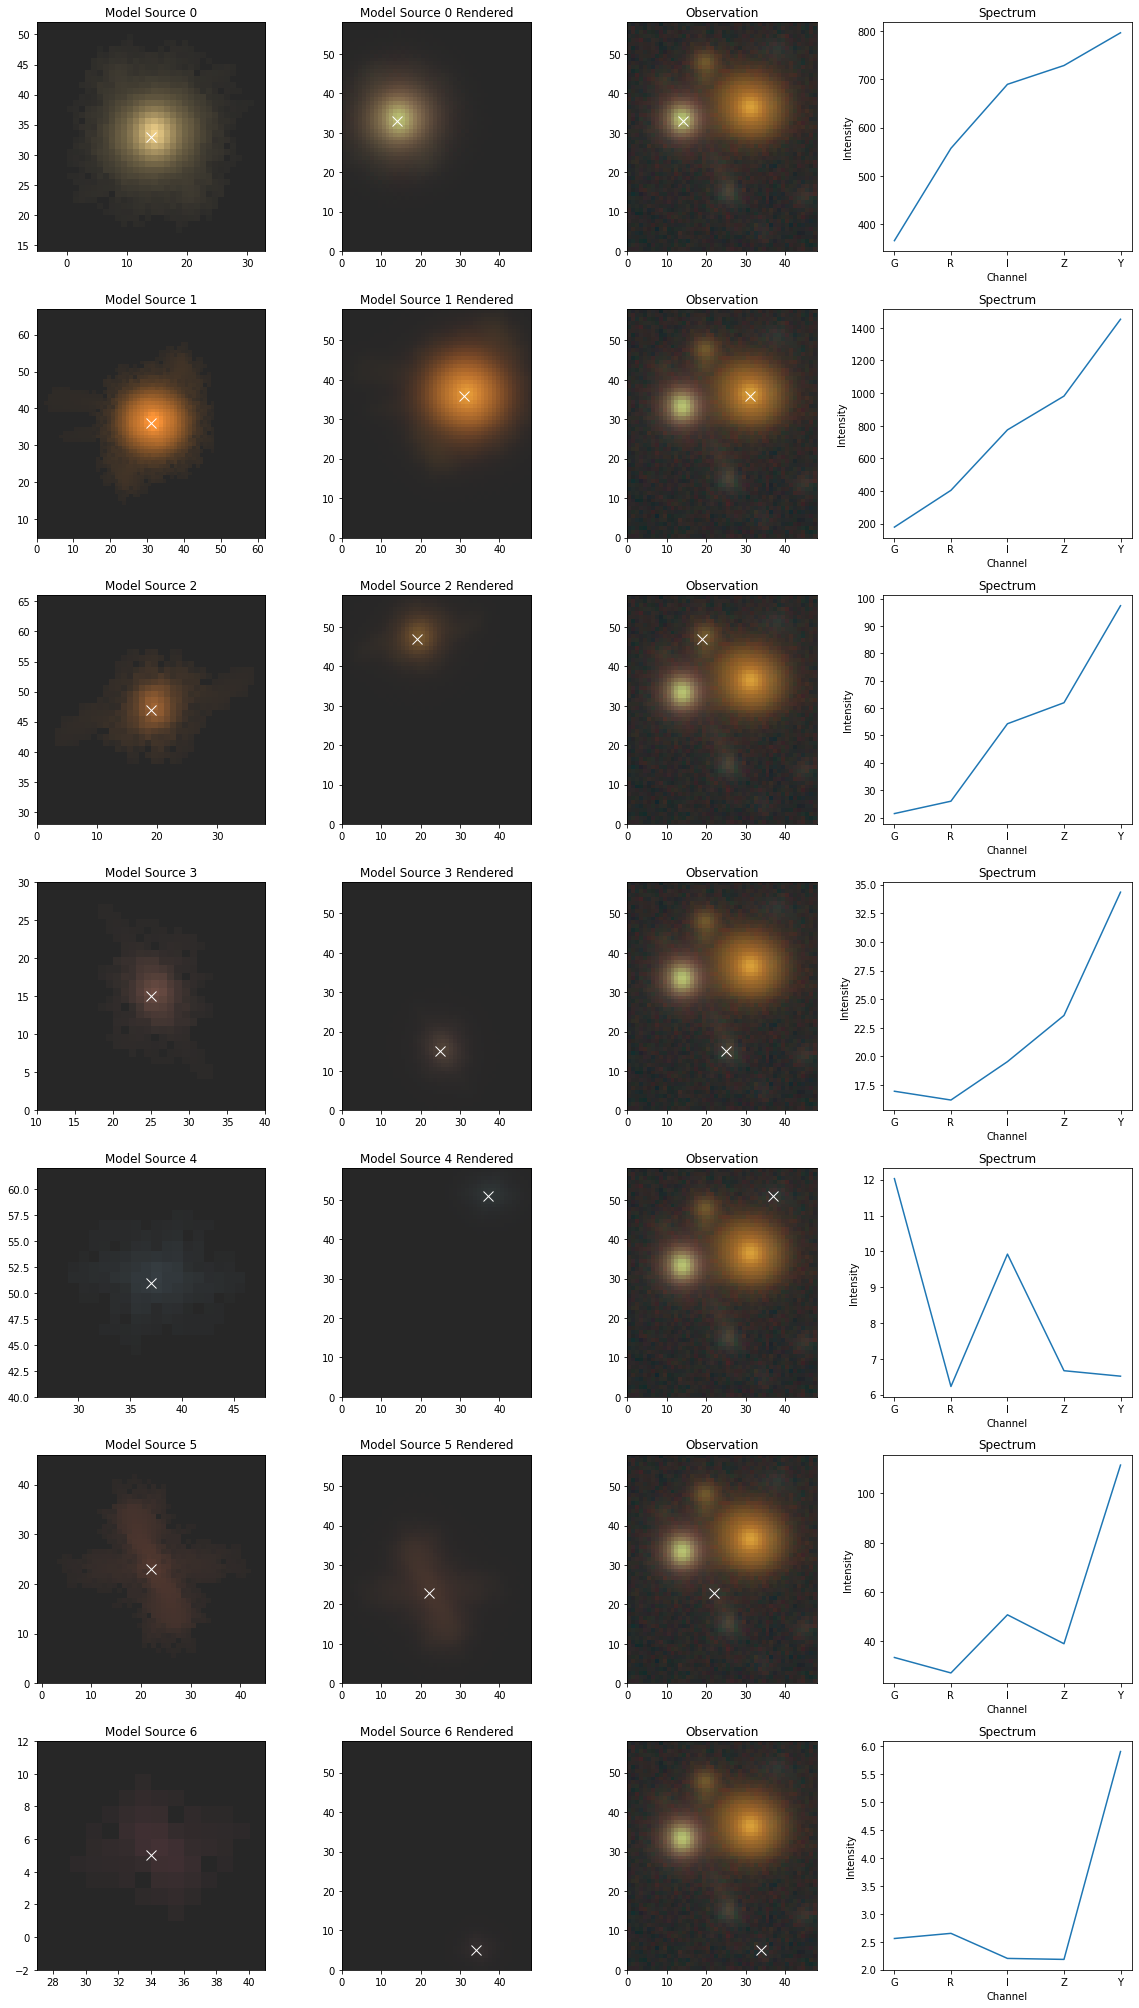

In [8]:
sources = [scarlet.ExtendedSource(frame, (peak[1], peak[0]), observation) for peak in peaks]

# Display the initial guess for each source
scarlet.display.show_sources(sources,
                             norm=norm,
                             observation=observation,
                             show_rendered=True,
                             show_observed=True)
plt.show()

## Exercise:

1. Experiment with the above code by using ; and using `MultiComponentSource`, which models a source as two components (a bulge and a disk) that are each symmetric and montonically decreasing from the peak.

# Deblending a scene

The `Blend` class contains the list of sources, the observation(s), and any other configuration parameters necessary to fit the data.

In [9]:
blend = scarlet.Blend(sources, observation)

Next we can fit a model, given a maximum number of iterations and the relative error required for convergence.

CPU times: user 1.21 s, sys: 7.49 ms, total: 1.22 s
Wall time: 1.22 s
scarlet ran for 69 iterations to logL = 30012.81883076545


Text(0, 0.5, 'log-Likelihood')

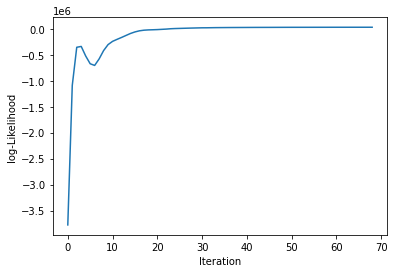

In [10]:
# Fit the data until the relative error is <= 1e-3,
# for a maximum of 200 iterations
blend = scarlet.Blend(sources, observation)
%time blend.fit(200, e_rel = 1e-3)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend.loss), -blend.loss[-1]))
plt.plot(-np.array(blend.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')

There are two options for displaying the scene, using `scarlet.display.show_scene` function. This shows the model along with the observation information and the residuals defined as: `observation.images - model`. 

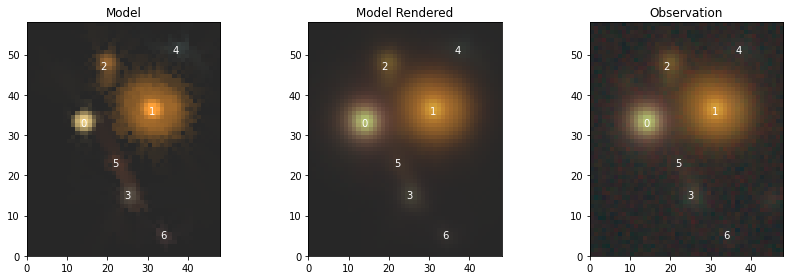

In [11]:
scarlet.display.show_scene(sources, norm=norm, 
                           observation=observation, 
                           linear=True,
                           show_model=True,
                           show_rendered=True,
                           show_observed=True,
                           #add_boxes=True
                          )
plt.show()

You can also do it by hand. 

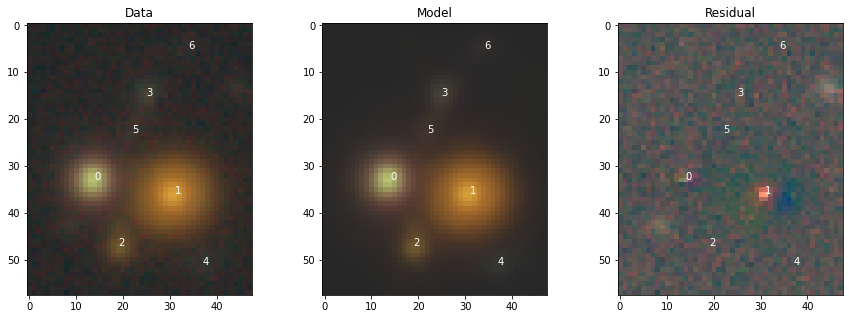

In [12]:
# Load the model and calculate the residual
model = blend.get_model()
model_ = observation.render(model)  # adapt model to observations. 
residual = images-model_

# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model_, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual)

# Show the data, model, and residual
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")

for k,component in enumerate(blend):
    y,x = component.center
    ax[0].text(x, y, k, color="w")
    ax[1].text(x, y, k, color="w")
    ax[2].text(x, y, k, color="w")
plt.show()

## Exercises

1. Experiment by running the above code using different source models (for example `MultiComponentSource` or `PointSource`) to see how initializtion affects the belnding results.

2. Change the value of `e_rel` in the above fit and try to understand how it affects the results. 